# ⚠️ This notebook is the second and NOT our final notebook
It shows part of our journey for training a CNN model to classify ASL gestures. <br>
### Used dataset: [ASL Alphabet](https://www.kaggle.com/grassknoted/asl-alphabet)
Here we tried to improve the results and train a model with a better dataset that would be closer to normal non-lab environments. <br> We used the ASL Alphabet dataset which looks much more realistic and wide in range of angles. <br>
Although this attempt yielded much better results, we still aimed to improve the model's fitting, so we turned to the third and final attempt. <br>
<br><br>
This code is not final! read carefully. It shows the code refining progress.

## Imports

In [1]:
import os
import glob
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import CSVLogger
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Constants

In [2]:
VERSION = "5"
TRAINING_SET_SRC_PATH = "../resources/sign_mnist_train.csv"
TEST_SET_SRC_PATH = "../resources/sign_mnist_test.csv"
TRAINED_MODEL_PATH = f"../resources/trained_model_{VERSION}.h5"
TRAINING_LOG_PATH = f"../resources/training_{VERSION}.log"
CHECKPOINT_PATH = "../resources/checkpoint/weights_{epoch:02d}.hdf5"
IMAGE_A_PATH = "../resources/A.jpeg"
ASL_TRAIN_SET_PATH = "../resources/asl_data_set/asl_alphabet_train/asl_alphabet_train"
SIZE = 64
CLASSES = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TEST_SET_SIZE = 0.3
CONTINUE_FIT = False
NUM_OF_EPOCHS = 35

## Dataset Loading & Initial Evaluation

In [3]:
labels = []
features = []

for i, c in enumerate(CLASSES):
    file_list = glob.glob(f"{ASL_TRAIN_SET_PATH}/{c}/*.jpg")
    for item in file_list:
        features.append(item)
        labels.append(i)
print(f"Amount of features: {len(features)} ; Amount of labels: {len(labels)}")

Amount of features: 78000 ; Amount of labels: 78000


## Data pre processing and normalization 
CNN are known to converges faster and better on normalized data <br>
at scale of [0..1] (than on [0..255]).

In [4]:
def pre_processing(img: np.ndarray, size: int = SIZE, should_grayscale: bool = False) -> np.ndarray:
    img = cv.resize(img, (size, size))
    if should_grayscale:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return img.astype(np.int) / 255

In [5]:
train_values = []
train_labels = []

for f in features:
    img = cv.imread(f, cv.IMREAD_GRAYSCALE)
    train_values.append(pre_processing(img))

for l in labels:
    train_labels.append(l)

In [6]:
train_values, validation_values, train_labels, validation_labels = train_test_split(train_values, train_labels,test_size=TEST_SET_SIZE)
print("Train data : ",len(train_values),len(train_labels))
print("Validation data : ",len(validation_values),len(validation_labels))

Train data :  54600 54600
Validation data :  23400 23400


## Visualization of the dataset's variance
Here we can see that the dataset's classes are distributed in relatively equal form and we have enough samples of each class.

<AxesSubplot:ylabel='count'>

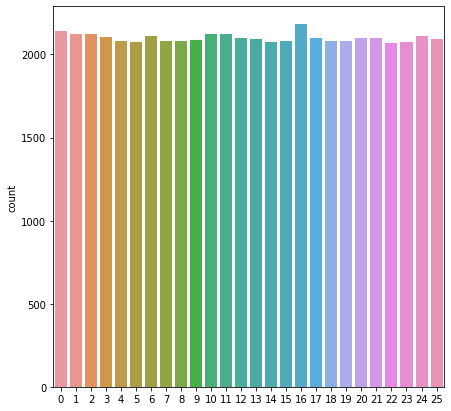

In [7]:
plt.figure(figsize = (7, 7))
sns.color_palette("Paired")
sns.countplot(x=train_labels)

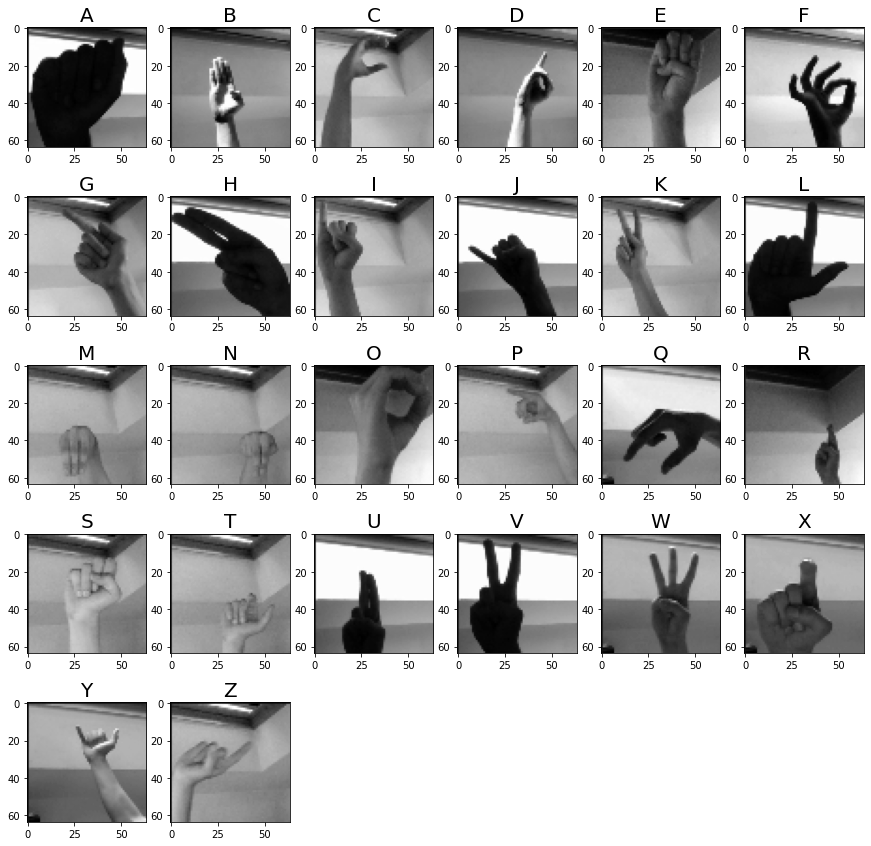

In [8]:
plt.figure(figsize=(15,15))
for i, c  in enumerate(CLASSES):
    for j, v in enumerate(train_labels):
        if v == i:
            plt.subplot(5, 6, i+1)
            plt.imshow(train_values[j], cmap="gray")
            plt.title(str(c),fontdict=dict({'fontsize' : 20}))
            break

## Label Binarization
Here we binarize lables in a one-vs-all fasion. 
#### What does it mean?
We convert our labels to classes in a binary manner. <br> 
That means that every label is switched from a single-value-label to a set of binary labels. <br>
**For example:** "3" is turned into: (0,0,0,**1**,0,0,0,0,0...)

In [9]:
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
validation_labels = label_binarizer.fit_transform(validation_labels)

In [10]:
train_values = np.array(train_values).reshape(-1, SIZE, SIZE, 1)
validation_values = np.array(validation_values).reshape(-1, SIZE, SIZE, 1)

## Data augmentation using keras.

1. Accepting a batch of images used for training.
2. Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
3. **Replacing the original batch** with the new, randomly transformed batch.
4. Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

*data augmentation illustration*<br>
<img src="https://www.pyimagesearch.com/wp-content/uploads/2019/07/keras_data_augmentation_header.png" alt="data-augmentation" width="250"/>

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(train_values)

## Creating the CONVOLUTIONAL NEURAL NETWORKS

In [12]:
if os.path.exists(TRAINED_MODEL_PATH) and CONTINUE_FIT:
    print("Found a backup trained model file, will load now...")
    model = load_model(TRAINED_MODEL_PATH)
    print("Loaded model file:")
else: 
    model = Sequential()
    model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (SIZE, SIZE, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 512 , activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units = len(CLASSES) , activation = 'softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    print("Couldn't find an existing model file. Created a new one:")
model.summary()

Couldn't find an existing model file. Created a new one:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 50)        200       
_________________________________________________________________

2021-08-26 01:31:04.079084: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model Training

In [13]:
# this will be passed as a callback to the model.fit action, in order to Reduce learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [14]:
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='loss', verbose=1, save_best_only=True, mode='auto', save_freq=1, save_weights_only=True)

In [15]:
num_of_epochs = NUM_OF_EPOCHS
if CONTINUE_FIT:
    model.load_weights("../resources/checkpoint/" + os.listdir("../resources/checkpoint/")[0])
    num_of_epochs = NUM_OF_EPOCHS - int(os.listdir("../resources/checkpoint/")[0].split("_")[1]) + 1
    print(f"After loading the exisiting weights, we're left with '{num_of_epochs}' epochs to run")
if not os.path.exists(TRAINED_MODEL_PATH) or CONTINUE_FIT:
    csv_logger = CSVLogger(TRAINING_LOG_PATH, separator=',', append=False)
    history = model.fit(datagen.flow(train_values, train_labels, batch_size = 50) ,epochs = num_of_epochs , validation_data = (validation_values, validation_labels) , callbacks = [learning_rate_reduction ,csv_logger, checkpoint])
    model.save(TRAINED_MODEL_PATH)
    history = history.history
else:
    history = pd.read_csv(TRAINING_LOG_PATH, sep=',', engine='python')


2021-08-26 01:31:05.308617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/35
   1/1092 [..............................] - ETA: 17:38 - loss: 5.0103 - accuracy: 0.0400
Epoch 00001: loss improved from inf to 5.01034, saving model to ../resources/checkpoint/weights_01.hdf5
   2/1092 [..............................] - ETA: 4:41 - loss: 5.2377 - accuracy: 0.0400 
Epoch 00001: loss did not improve from 5.01034
   3/1092 [..............................] - ETA: 4:31 - loss: 4.9649 - accuracy: 0.0333
Epoch 00001: loss improved from 5.01034 to 4.96491, saving model to ../resources/checkpoint/weights_01.hdf5
   4/1092 [..............................] - ETA: 4:35 - loss: 4.7158 - accuracy: 0.0550
Epoch 00001: loss improved from 4.96491 to 4.71581, saving model to ../resources/checkpoint/weights_01.hdf5
   5/1092 [..............................] - ETA: 4:35 - loss: 4.6520 - accuracy: 0.0560
Epoch 00001: loss improved from 4.71581 to 4.65204, saving model to ../resources/checkpoint/weights_01.hdf5
   6/1092 [..............................] - ETA: 4:37 - loss: 4.57

## Evaluation

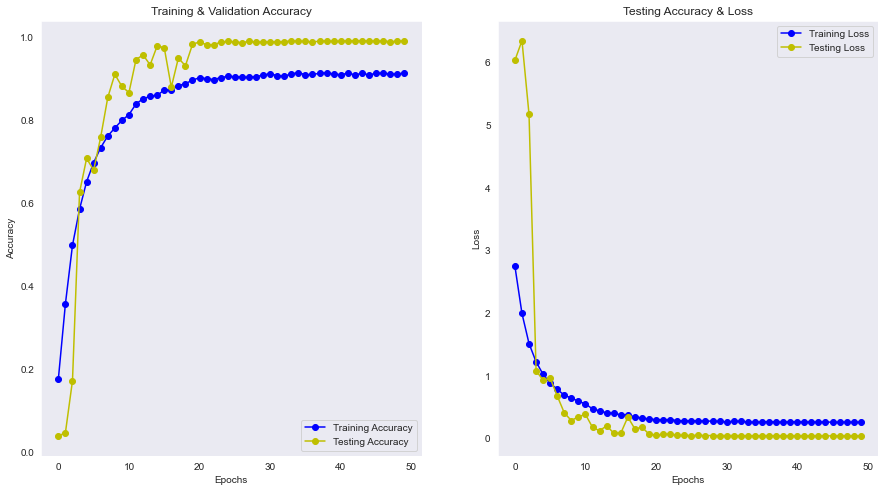

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
fig.set_size_inches(15,8)

ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

#### Classification report

In [ ]:
predictions = np.argmax(model.predict(test_values), axis=-1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(test_df_src["label"], predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      0.97      0.98       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      0.83      0.91       245
     Class 4       1.00      0.93      0.97       498
     Class 5       1.00      1.00      1.00       247
     Class 6       0.99      0.98      0.99       348
     Class 7       0.98      1.00      0.99       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       0.85      1.00      0.92       209
    Class 12       0.92      0.96      0.94       394
    Class 13       0.95      1.00      0.97       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       0.96      0.95      0.96       144
    Class 18       0.97    

<AxesSubplot:>

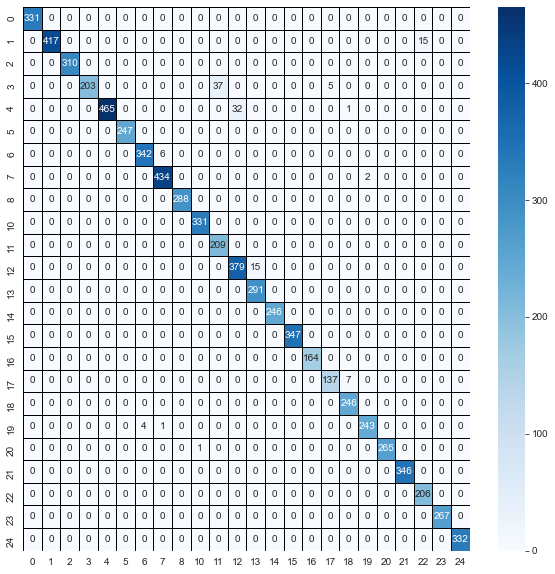

In [ ]:
cm = confusion_matrix(test_df_src["label"], predictions)
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

## Test with a clear image from outside the dataset
The image is of the letter "A" sign

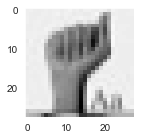

In [ ]:
image_a = cv.imread(IMAGE_A_PATH, cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (2,2))
plt.imshow(image_a, cmap="gray")

The perdiction is indeed of the letter A

In [ ]:
a_reshaped = image_a.reshape(-1,28,28,1)/ 255
np.argmax(model.predict(a_reshaped), axis=-1)

array([0])

array([7])

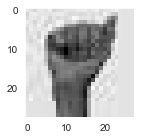

In [ ]:
img = cv.imread("../resources/a2.jpeg", cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (2,2))
plt.imshow(img, cmap="gray")
reshaped = img.reshape(-1,28,28,1) / 255
np.argmax(model.predict(reshaped), axis=-1)

array([18])

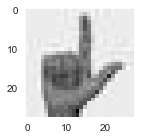

In [ ]:
img = cv.imread("../resources/l.jpeg", cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (2,2))
plt.imshow(img, cmap="gray")
reshaped = img.reshape(-1,28,28,1)/ 255
np.argmax(model.predict(reshaped), axis=-1)

array([15])

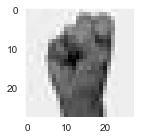

In [ ]:
img = cv.imread("../resources/s.jpeg", cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (2,2))
plt.imshow(img, cmap="gray")
reshaped = img.reshape(-1,28,28,1)/ 255
np.argmax(model.predict(reshaped), axis=-1)

## The following code block was improved and taken out to this file: ```../utils/image_processing.py```

In [ ]:
import mediapipe as mp
from keras.models import Model
from typing import NamedTuple, Tuple

def load_image(file_path: str) -> np.ndarray:
    return cv.imread(file_path)


def recognize_hand_in_image(img: np.ndarray, should_flip_horizontal: bool, static_image_mode: bool = True, max_num_hands: int = 1) -> NamedTuple or None:
    img = img.copy()
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=static_image_mode, max_num_hands=max_num_hands) as hands:
        if should_flip_horizontal:
            img = cv.flip(img, 1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img.flags.writeable = False
        return hands.process(img)


def draw_hand(img:np.ndarray, hands: NamedTuple) -> np.ndarray:
    """hands: (landmarks, handness)"""
    img = img.copy()
    mp_drawing = mp.solutions.drawing_utils
    drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands
    if hands.multi_hand_landmarks:
        for hand_landmarks in hands.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                        drawing_styles.get_default_hand_landmark_style(),
                                        drawing_styles.get_default_hand_connection_style())
    return img


def get_hand_frame(img: np.ndarray, hands: NamedTuple, padding: float = 0.2) -> Tuple[tuple] or None:
    img = img.copy()
    h , w, _ = img.shape
    h_landmarks = []
    w_landmarks = []
    result = None
    if hands.multi_hand_landmarks:
        for hand_landmarks in hands.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                w_landmarks.append(int(lm.x * w))
                h_landmarks.append(int(lm.y * h))
        max_x, max_y, min_x, min_y = max(w_landmarks), max(h_landmarks), min(w_landmarks), min(h_landmarks)
        pad_w = int((max_x - min_x) * padding)
        pad_h = int((max_y - min_y) * padding)
        result = (min_x-pad_w, min_y-pad_h), (max_x+pad_w, max_y+pad_h)
    return result 


def draw_frame(img, top_left_point: tuple, bottom_right_point: tuple, border_color: tuple = (255, 0, 0), border_width: int = 4) -> np.ndarray:
    img = img.copy()
    cv.rectangle(img, top_left_point, bottom_right_point, border_color, border_width)
    return img


def crop_hand(img, top_left_point: tuple, bottom_right_point: tuple, crop_size: int):
    img = img.copy()
    top_left_x = top_left_point[0]
    top_left_y = top_left_point[1]
    bottom_right_x = bottom_right_point[0]
    bottom_right_y = bottom_right_point[1]

    cropped = img[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

    # Keeping aspect ratio of the image according to max(width,height)
    w = bottom_right_x - top_left_x
    h = bottom_right_y - top_left_y
    if w >= h:
        dim = (crop_size, int(crop_size * (h/w)))
    else:
        dim = (int(crop_size * (w/h)), crop_size)

    resized = cv.resize(cropped, dim, interpolation=cv.INTER_AREA)
    result = np.zeros((crop_size, crop_size, 3)).astype(np.float32)
    result[0:dim[1], 0:dim[0]] = resized
    return result


def bgr_to_grayscale(img: np.ndarray, is_3d: bool) -> np.ndarray:
    img = img.copy()
    y, x, _ = img.shape
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if not is_3d:
        result = gray
    else:
        gray_3d = np.zeros((y, x, 3))
        gray_3d[0:y, 0:x, 0] = gray
        gray_3d[0:y, 0:x, 1] = gray
        gray_3d[0:y, 0:x, 2] = gray
        result = gray_3d
    return result


def pre_processing(img: np.ndarray, size: int) -> np.ndarray:
    img = bgr_to_grayscale(img, is_3d=False)
    normalized = img.astype(np.int) / 255
    return normalized.reshape(-1, size, size, 1)


def predict(model: Model, img: np.ndarray, size: int) -> np.array:
    img = pre_processing(img, size)
    return np.argmax(model.predict(img), axis=-1)


def plot_image(img: np.ndarray, cmap: str = "gray", figsize: Tuple[int] = (2,2)) -> None:
    img = img.copy() 
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.figure(figsize = figsize)
    plt.imshow(img, cmap=cmap)


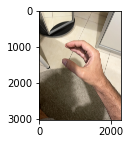

In [ ]:
PATH = "../resources/our_creapy_hands/hand_3.jpg"
SIZE = 30
img = load_image(PATH)
plot_image(img)

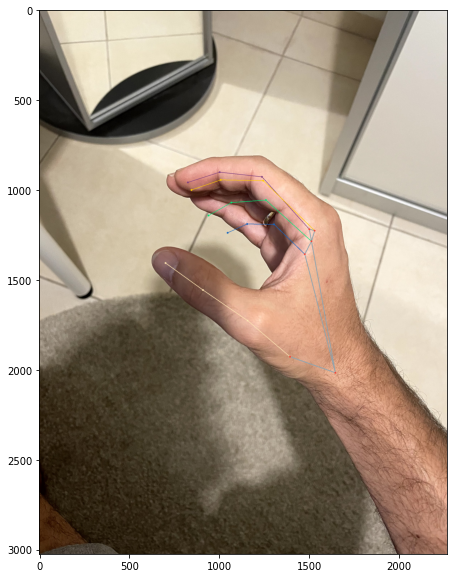

In [ ]:
hands = recognize_hand_in_image(img, False)
img_with_hands = draw_hand(img, hands)
plot_image(img_with_hands, figsize=(10,10))

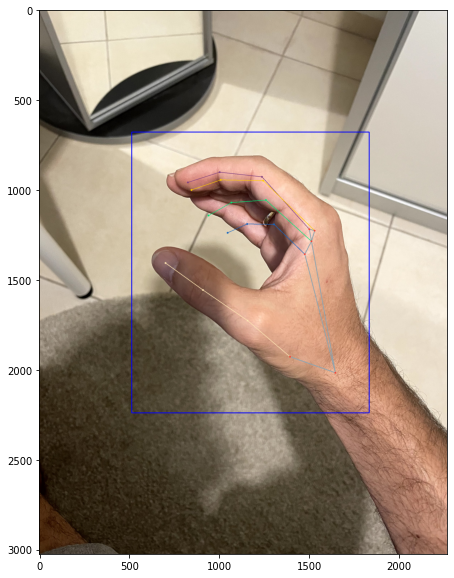

In [ ]:
frame = get_hand_frame(img_with_hands, hands)
img_with_frame = draw_frame(img_with_hands, frame[0], frame[1])
plot_image(img_with_frame, figsize=(10, 10))



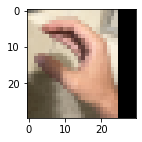

In [ ]:
cropped_hand_img = crop_hand(img, frame[0], frame[1], SIZE)
plot_image(cropped_hand_img.astype(np.uint8))